# <a id='toc1_'></a>[UCRB PRISM Analysis](#toc0_)

Author: Daniel Hogan
Created: September 9, 2023

In this notebook, we produce several figures included in the publication and look at annual and seasonal differences between precipitation during the Millennium Drought and the Baseline periods.

**Table of contents**<a id='toc0_'></a>    
- [UCRB PRISM Analysis](#toc1_)    
    - [Imports](#toc1_1_1_)    
- [Pull in SNTL Data, basins and closest sntl sites](#toc2_)    
- [Open PRISM data](#toc3_)    
  - [Precipitation](#toc3_1_)    
    - [Open the PRISM HCDN averaged basin data for 1895-2022](#toc3_1_1_)    
    - [Open 4-km PRISM data over the entire UCRB](#toc3_1_2_)    
  - [Download PRISM Temperatures](#toc3_2_)    
    - [Open monthly mean temperature data over the UCRB](#toc3_2_1_)    
  - [Produce HCDN basin mean temperture and precipitation dataset](#toc3_3_)    
    - [Functions for computing seasonal precipitation totals and anomalies](#toc3_3_1_)    
    - [Save Seasonal Precipitation Data for each HCDN Basin](#toc3_3_2_)    
    - [Calculate seasonal mean and sum and annual mean and sum of precipitation for each HCDN basin.](#toc3_3_3_)    
  - [Create plot for PRISM normals](#toc3_4_)    
  - [Create plot of seasonal precipitation using PRISM normal data](#toc3_5_)    
    - [Plot Monthly Mean Precipitation For December through May](#toc3_5_1_)    
    - [Plot Annual Mean Precipitation](#toc3_5_2_)    
  - [Plot baseline annual mean precipitation](#toc3_6_)    
    - [Reset resolution to plot 4km PRISM data](#toc3_6_1_)    
  - [Plot Millennium Drought annual mean precipitation](#toc3_7_)    
  - [Plot Difference Between Millennium Drought and Baseline Mean Annual Precipitation](#toc3_8_)    
  - [Grab HCDN precipitation gages and separate gages with and without significant changes](#toc3_9_)    
  - [Figure used in Manuscript](#toc3_10_)    
    - [Plot individual changes if necessary](#toc3_10_1_)    
  - [Plot annual precipitation change between periods](#toc3_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource
import matplotlib as mpl

# <a id='toc2_'></a>[Pull in SNTL Data, basins and closest sntl sites](#toc0_)

In [2]:
#EPSG code
co_epsg = 32613
# UCRB Basins
ucrb_hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
ucrb_hcdn_basins = ucrb_hcdn_basins.set_crs(32613,allow_override=True)
bad_gages = ucrb_hcdn_basins.index.isin(['09306242','09378170','09378630']) 
ucrb_hcdn_basins = ucrb_hcdn_basins[~bad_gages]
ucrb_hcdn_basins = ucrb_hcdn_basins.set_crs(epsg='32613', allow_override=True)
# ucrb_hcdn_basins = ucrb_hcdn_basins.to_crs(co_epsg)
# pull in sntl
hcdn_sntl_swe_ds = xr.open_dataset('../data/snowdata/ucrb_hcdn_sntl_all_20220930.nc')

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [3]:
# Clean SNTL data
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC']>=0))
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC'].diff(dim='Date')<20))

# <a id='toc3_'></a>[Open PRISM data](#toc0_)

## <a id='toc3_1_'></a>[Precipitation](#toc0_)
### <a id='toc3_1_1_'></a>[Open the PRISM HCDN averaged basin data for 1895-2022](#toc0_)

In [46]:
# Download PRISM normals if not already created as a netcdf file
if not os.path.exists('../data/precipdata/prism_4km_ppt_normals.nc'):
       outpath = '../data/precipdata/PRISM/PRISM_ppt_30yr_normal_800mM4_all_bil/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
       prism_list = []
       for file in files:
              prism_list.append(rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry))
       prism_normals_ds = xr.concat(prism_list, dim='band')
       prism_normals_ds = prism_normals_ds.rename({'band':'month'})

       prism_normals_ds = prism_normals_ds.assign_coords({
              'month': [1,2,3,4,5,6,7,8,9,10,11,12]})
       prism_normals_ds.to_netcdf('../data/precipdata/prism_4km_ppt_normals.nc')
else:
       prism_normals_ds = xr.open_dataset('../data/precipdata/prism_4km_ppt_normals.nc')

if not os.path.exists('../data/precipdata/prism_4km_ucrb_hcdn.nc'):
       # Download PRISM precipitation from 4km product 
       # If we want the same values, need to rerun this with all the data
       outpath = '../data/precipdata/PRISM/PRISM_ppt_stable_4km/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry, all_touched=True)
              prism_list.append(tmp)
       prism_4km_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_ds = prism_4km_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ds = prism_4km_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_ds = prism_4km_ds.sortby('month')
       prism_4km_ds = prism_4km_ds.sel(month=slice('1981-01-01', '2022-09-01'))
else:
       prism_4km_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb_hcdn.nc')

In [50]:
# Download historic PRISM precipitation from 4km product 
if os.path.exists('../data/precipdata/prism_4km_ucrb_hcdn.nc'):
       outpath = '/storage/dlhogan/sos/data/PRISM_ppt/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry, all_touched=True)
              prism_list.append(tmp)
       prism_4km_historic_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_historic_ds = prism_4km_historic_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_historic_ds = prism_4km_historic_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_historic_ds = prism_4km_historic_ds.sortby('month')
       prism_4km_ucrb_hcdn_ds = xr.concat([prism_4km_historic_ds, prism_4km_ds['__xarray_dataarray_variable__']], dim='month', join='override')
       prism_4km_ucrb_hcdn_ds.to_netcdf('../data/precipdata/prism_4km_ucrb_hcdn.nc')
else:
       prism_4km_ucrb_hcdn_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb_hcdn.nc')

ValueError: cannot align objects with join='override' with matching indexes along dimension 'y' that don't have the same size

### <a id='toc3_1_2_'></a>[Open 4-km PRISM data over the entire UCRB](#toc0_)

In [12]:
# Open PRISM 4km for the entire UCRB
prism_4km_ucrb_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
# convert month to datetime
prism_4km_ucrb_ds['month'] = pd.to_datetime(prism_4km_ucrb_ds['month'],format='%Y%m%d')

# Create a filter to remove dates after 1999-10-01
prism_4km_pre_ds = prism_4km_ucrb_ds.sel(month=slice('1963-10-01', '1999-09-30'))
prism_4km_post_ds = prism_4km_ucrb_ds.sel(month=slice('1999-10-01', '2022-09-30'))


## <a id='toc3_2_'></a>[Download PRISM Temperatures](#toc0_)
### <a id='toc3_2_1_'></a>[Open monthly mean temperature data over the UCRB](#toc0_)

In [18]:
if not os.path.exists('../data/etdata/prism_tmean_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '/storage/dlhogan/sos/data/PRISM/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 39)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_tmean_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_tmean_ds = prism_4km_tmean_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean_ds = prism_4km_tmean_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_tmean_ds = prism_4km_tmean_ds.sortby('month')
       prism_4km_tmean_ds = prism_4km_tmean_ds.sel(month=slice('1895-01-01', '2022-09-01'))

       prism_4km_tmean_ds.to_netcdf('../data/etdata/prism_tmean_4km_ucrb.nc')
else:
       prism_4km_tmean_ds = xr.open_dataset('../data/etdata/prism_tmean_4km_ucrb.nc')

## <a id='toc3_3_'></a>[Produce HCDN basin mean temperture and precipitation dataset](#toc0_)

In [15]:
# For normals product
# Filter out bad data
prism_normals_ds_ma = prism_normals_ds.where(prism_normals_ds>=0, drop=True).sum(dim='month')

# Reproject the masked dataset and clip to HCDN boundaries
prism_normals_ds_ma = prism_normals_ds_ma.rio.write_crs(co_epsg)
prism_normals_ds_ma = prism_normals_ds_ma.rio.set_crs(co_epsg)
prism_normals_hcdn_ds = prism_normals_ds_ma.rio.clip(ucrb_hcdn_basins.geometry)

# Filter out other bad data
prism_normals_hcdn_ds_ma = prism_normals_ds_ma.where((prism_normals_ds>=0) & (prism_normals_ds_ma<5000))

In [19]:
# For 4 km product
# Filter out bad data
prism_4km_ucrb_hcdn_ds_ma = prism_4km_ucrb_hcdn_ds.where(prism_4km_ucrb_hcdn_ds>=0)
prism_4km_tmean_ds_ma = prism_4km_tmean_ds.where(prism_4km_tmean_ds>=-50)

# Reproject the masked dataset and clip to HCDN boundaries
prism_4km_ucrb_hcdn_ds_ma = prism_4km_ucrb_hcdn_ds_ma.rio.write_crs(co_epsg)
prism_4km_hcdn_ds = prism_4km_ucrb_hcdn_ds_ma.rio.clip(ucrb_hcdn_basins.geometry)

# Filter out other bad data
prism_4km_hcdn_ds_ma = prism_4km_ucrb_hcdn_ds_ma.where((prism_4km_ucrb_hcdn_ds_ma<5000) & (prism_4km_ucrb_hcdn_ds_ma>=0))
# prism_4km_hcdn_ds_ma.name = 'ppt'
prism_4km_hcdn_ds_ma=prism_4km_hcdn_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})

prism_4km_tmean_hcdn_ds_ma = prism_4km_tmean_ds_ma.where((prism_4km_tmean_ds_ma<100) & (prism_4km_tmean_ds_ma>=-100))
# prism_4km_tmean_hcdn_ds_ma.name = 'tmean'
prism_4km_tmean_hcdn_ds_ma=prism_4km_tmean_hcdn_ds_ma.rename_vars({'__xarray_dataarray_variable__':'tmean'})



### <a id='toc3_3_1_'></a>[Functions for computing seasonal precipitation totals and anomalies](#toc0_)

In [21]:
# Seasonal Precipitation Plot
def season_sum(ds, calendar="standard"):
    tmp = (ds).resample(month='QS-OCT').sum()
    tmp = tmp.where(tmp>0, np.nan)
    # Calculate the weighted average
    return tmp

def season_mean(ds, calendar="standard"):

    # Calculate the weighted average
    return (ds).resample(month='QS-OCT').mean()

def annual_sum(ds, calendar="standard"):

    # Calculate the weighted average
    return ds.resample(month='A-OCT').sum()

def annual_mean(ds, calendar="standard"):

    # Calculate the weighted average
    return ds.resample(month='A-OCT').mean()

def get_monthly_prism_anomalies(ds):
    # Get monthly normalized values of sublimation/evaporation and precipitation
    ds_mean = ds.groupby('month.month').mean("month")
    ds_std = ds.groupby('month.month').std("month")

    stand_anomalies = xr.apply_ufunc(
        lambda x,m,s: (x-m)/s,
        ds.groupby("month.month"),
        ds_mean,
        ds_std,
        dask='parallelized'
    )
    return stand_anomalies

### <a id='toc3_3_2_'></a>[Save Seasonal Precipitation Data for each HCDN Basin](#toc0_)

In [42]:
# Seasonal PRISM sum for precipitation at each grid cell
prism_4km_hcdn_seasonal_ds = season_sum(prism_4km_hcdn_ds_ma)
prism_4km_hcdn_seasonal_ma_ds = prism_4km_hcdn_seasonal_ds.where(prism_4km_hcdn_seasonal_ds>0)

# save as netcdf if necessary
if not os.path.exists('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc'):
    ds_list = []
    for i, gage in enumerate(ucrb_hcdn_basins.gage):
        basin = ucrb_hcdn_basins[ucrb_hcdn_basins['gage']==gage]
        ds = prism_4km_hcdn_seasonal_ma_ds.rio.clip(basin.geometry, all_touched=True).mean(dim=['x','y'])
        # add a coordinate for the gage name
        ds = ds.assign_coords({'station_id':gage})
        ds = ds.drop_vars('spatial_ref')
        ds_list.append(ds)
    prism_4km_hcdn_mean_ds = xr.concat(ds_list, dim='station_id')
    prism_4km_hcdn_mean_ds.to_netcdf('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')
else:
    prism_4km_hcdn_mean_ds = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')

# Annual PRISM sum for precipitation at each grid cell
prism_4km_hcdn_annual_ds = annual_sum(prism_4km_hcdn_seasonal_ds)
prism_4km_hcdn_annual_ds_ma_ds = prism_4km_hcdn_annual_ds.where(prism_4km_hcdn_annual_ds>0)

# Seasonal PRISM mean for temperature at each grid cell
prism_4km_hcdn_tmean_seasonal_ds = season_mean(prism_4km_tmean_hcdn_ds_ma)
prism_4km_hcdn_tmean_seasonal_ma_ds = prism_4km_hcdn_tmean_seasonal_ds.where(prism_4km_hcdn_tmean_seasonal_ds>-100)

# Annual PRISM mean for temperature at each grid cell
prism_4km_hcdn_tmean_annual_ds = annual_mean(prism_4km_tmean_hcdn_ds_ma)
prism_4km_hcdn_tmean_annual_ds_ma_ds = prism_4km_hcdn_tmean_annual_ds.where(prism_4km_hcdn_tmean_annual_ds>100)

Quickly visualize what this data looks like for a spring

In [38]:
prism_4km_hcdn_mean_ds.sel(station_id='09034900')

<xarray.Dataset>
Dimensions:     (month: 511)
Coordinates:
  * month       (month) datetime64[ns] 1895-01-01 1895-04-01 ... 2022-07-01
    station_id  <U8 '09034900'
Data variables:
    ppt         (month) float32 504.3 221.8 181.5 375.4 ... 173.2 133.9 179.2

Text(0.5, 1.0, 'Mean Spring Precipitation = [308 308 308 308 308 308 308 308 308 308 308 308 308 308 308 308 308 308\n 308 308 308 308 308 308 308 308] mm')

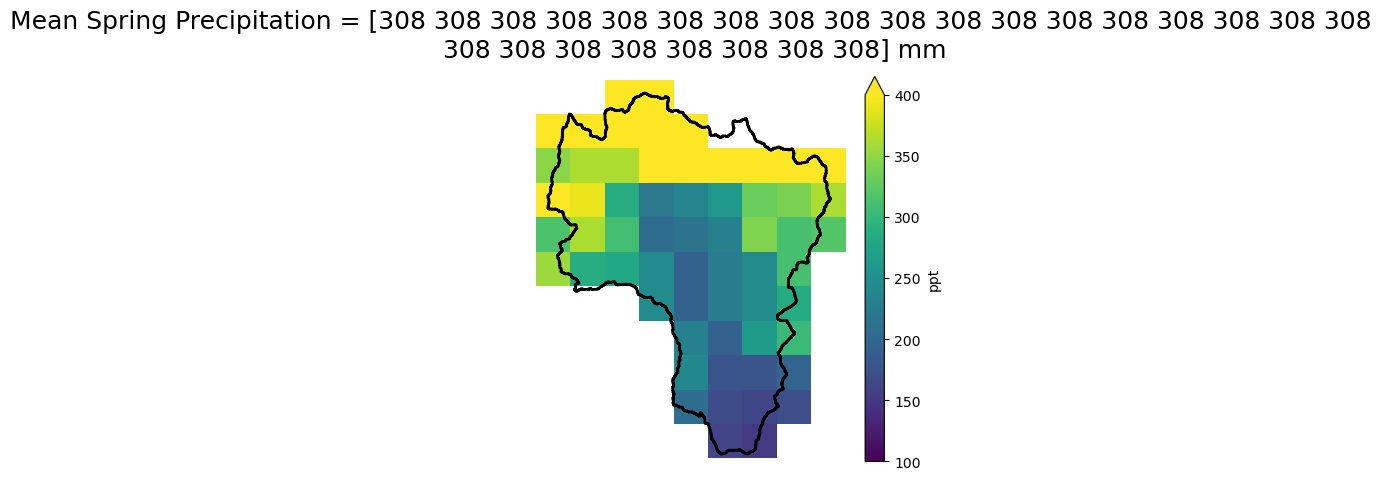

In [35]:
# plot spring precip for one year
east_river_polygon = ucrb_hcdn_basins[ucrb_hcdn_basins['gage']=='09112500']
# crop prism data to east river basin
prism_4km_hcdn_seasonal_ma_ds_east_river = prism_4km_hcdn_seasonal_ma_ds.rio.clip(east_river_polygon.geometry, all_touched=True)
year = 1999
fig, ax = plt.subplots(figsize=(5,5))

prism_4km_hcdn_seasonal_ma_ds_east_river.sel(month=f'{year}-04-01').ppt.plot(ax=ax, cmap='viridis', vmin=100, vmax=400)
# draw basin boundary
east_river_polygon.boundary.plot(ax=ax, color='k', linewidth=2)
# hide axis
ax.set_axis_off()
# add title
mean_spring_precip = prism_4km_hcdn_mean_ds.sel(month=f'{year}-04-01').ppt.values.astype(int)
ax.set_title(f'Mean Spring Precipitation = {mean_spring_precip} mm', size=18)


### <a id='toc3_3_3_'></a>[Calculate seasonal mean and sum and annual mean and sum of precipitation for each HCDN basin.](#toc0_)

In [15]:
# Compute the seasonal sum for pre and post ucrb prism
prism_4km_pre_seasonal_ds = season_mean(prism_4km_pre_ds)
prism_4km_pre_seasonal_ds_ma = prism_4km_pre_seasonal_ds.where(prism_4km_pre_seasonal_ds>0)

prism_4km_post_seasonal_ds = season_mean(prism_4km_post_ds)
prism_4km_post_seasonal_ds_ma = prism_4km_post_seasonal_ds.where(prism_4km_post_seasonal_ds>0)

# Compute the annual mean for pre and post ucrb prism
prism_4km_pre_annual_ds = annual_sum(prism_4km_pre_ds)
prism_4km_pre_annual_ds_ma = prism_4km_pre_annual_ds.where(prism_4km_pre_annual_ds>0)
prism_4km_post_annual_ds = annual_sum(prism_4km_post_ds)
prism_4km_post_annual_ds_ma = prism_4km_post_annual_ds.where(prism_4km_post_annual_ds>0)

# for all of these new products, rename __xarray_dataarray_variable__ to ppt
prism_4km_pre_seasonal_ds_ma=prism_4km_pre_seasonal_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_post_seasonal_ds_ma=prism_4km_post_seasonal_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_pre_annual_ds_ma=prism_4km_pre_annual_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_post_annual_ds_ma=prism_4km_post_annual_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})

In [20]:
def mean_percent_diff(ds1, ds2, month):
    if month is None:
        ds1_pre = ds1.mean(dim='month')
        ds2_post = ds2.mean(dim='month')
    else:
        ds1_pre = ds1.where(ds1.month.dt.month==month).mean(dim='month')
        ds2_post = ds2.where(ds2.month.dt.month==month).mean(dim='month')
    return (ds2_post-ds1_pre)

## <a id='toc3_4_'></a>[Create plot for PRISM normals](#toc0_)

In [24]:
# all values less than zero are nan
prism_normals_ds = prism_normals_ds.where(prism_normals_ds>0)
# compute the mean for each season (DJF, MAM, JJA, SON)
prism_normals_winter_ds = prism_normals_ds.where((prism_normals_ds.month==1) | (prism_normals_ds.month==2) | (prism_normals_ds.month==3)).sum(dim='month')
prism_normals_spring_ds = prism_normals_ds.where((prism_normals_ds.month==3) | (prism_normals_ds.month==4) | (prism_normals_ds.month==5)).sum(dim='month')
prism_normals_summer_ds = prism_normals_ds.where((prism_normals_ds.month==6) | (prism_normals_ds.month==7) | (prism_normals_ds.month==8)).sum(dim='month')
prism_normals_fall_ds = prism_normals_ds.where((prism_normals_ds.month==9) | (prism_normals_ds.month==10) | (prism_normals_ds.month==11)).sum(dim='month')
# get the value for december, january, february, march, april, may, and june
prism_normals_december_ds = prism_normals_ds.where(prism_normals_ds.month==12).sum(dim='month')
prism_normals_january_ds = prism_normals_ds.where(prism_normals_ds.month==1).sum(dim='month')
prism_normals_february_ds = prism_normals_ds.where(prism_normals_ds.month==2).sum(dim='month')
prism_normals_march_ds = prism_normals_ds.where(prism_normals_ds.month==3).sum(dim='month')
prism_normals_april_ds = prism_normals_ds.where(prism_normals_ds.month==4).sum(dim='month')
prism_normals_may_ds = prism_normals_ds.where(prism_normals_ds.month==5).sum(dim='month')

# compute annual mean normals
prism_normals_annual_ds = prism_normals_ds.sum(dim='month')
prism_normals_annual_ds = prism_normals_annual_ds.where(prism_normals_annual_ds>0)

# compute the percent of annual precipitation that falls in each season
prism_normals_winter_annual_percent_ds = (prism_normals_winter_ds/prism_normals_annual_ds) * 100
prism_normals_spring_annual_percent_ds = (prism_normals_spring_ds/prism_normals_annual_ds) * 100
prism_normals_summer_annual_percent_ds = (prism_normals_summer_ds/prism_normals_annual_ds) * 100
prism_normals_fall_annual_percent_ds = (prism_normals_fall_ds/prism_normals_annual_ds) * 100

# compute the percent of annual precipitation that falls in each month
prism_normals_december_annual_percent_ds = (prism_normals_december_ds/prism_normals_annual_ds) * 100
prism_normals_january_annual_percent_ds = (prism_normals_january_ds/prism_normals_annual_ds) * 100
prism_normals_february_annual_percent_ds = (prism_normals_february_ds/prism_normals_annual_ds) * 100
prism_normals_march_annual_percent_ds = (prism_normals_march_ds/prism_normals_annual_ds) * 100
prism_normals_april_annual_percent_ds = (prism_normals_april_ds/prism_normals_annual_ds) * 100
prism_normals_may_annual_percent_ds = (prism_normals_may_ds/prism_normals_annual_ds) * 100


In [37]:
src = rioxr.open_rasterio('../data/geodata/ucrb_dem_32613_150m.tif')
# mask values less than 0
src = src.where(src > 0)
# downsample to 800m
src = src.rio.reproject(dst_crs='EPSG:32613', resolution=789.1686447630818)
# mask values less than 0
src = src.where(src > 0)

# Create hillshade set up
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth
# Resolution of the normals map (around 800 meters)
dx, dy =789.1686447630818, 789.1686447630818

In [38]:
# Grab streamflow traces
ucrb_stream_traces = gpd.read_file('../data/geodata/Colorado_River_Basin_Rivers.geojson')
ucrb_stream_traces = ucrb_stream_traces.to_crs(32613)
# clip to UCRB boundary
ucrb_stream_traces = gpd.clip(ucrb_stream_traces, ucrb_basin_boundary)

## <a id='toc3_5_'></a>[Create plot of seasonal precipitation using PRISM normal data](#toc0_)

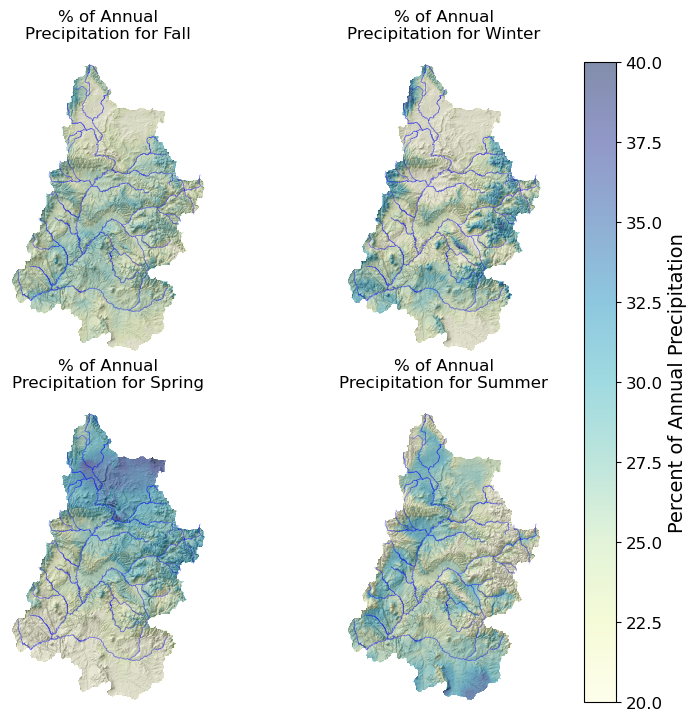

In [39]:
# Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
labels = ['Fall','Winter', 'Spring', 'Summer', ]
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.ravel()
for i, ds in enumerate([prism_normals_fall_annual_percent_ds,
                        prism_normals_winter_annual_percent_ds,
                        prism_normals_spring_annual_percent_ds,
                        prism_normals_summer_annual_percent_ds]):
    # im = ds.plot(ax=axs[i], cmap='YlGnBu', vmin=20, vmax=40, add_colorbar=False, alpha=0.5)
    axs[i].imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray', extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
    ucrb_stream_traces.plot(ax=axs[i], color='blue', linewidth=0.5,  zorder=1, alpha=0.5)    
    im = axs[i].imshow(ds.values, alpha=0.5, cmap='YlGnBu', vmin=20, vmax=40, extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
    axs[i].set_title('% of Annual\nPrecipitation for {}'.format(labels[i]))
    axs[i].set_axis_off()
    # turn off the colorbar
    # set the colorbar label to be Percent Difference
    # cbar = axs[i].collections[0].colorbar
    # cbar.set_label('(%)')
    # plot the hcdn basins
    # ucrb_hcdn_basins.plot(ax=axs[i], facecolor="none", edgecolor="none", linewidth=0.5)
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9, wspace=0, hspace=0.2)
cbar = fig.colorbar(im, ax=axs)
cbar.set_label('Percent of Annual Precipitation', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)

### <a id='toc3_5_1_'></a>[Plot Monthly Mean Precipitation For December through May](#toc0_)

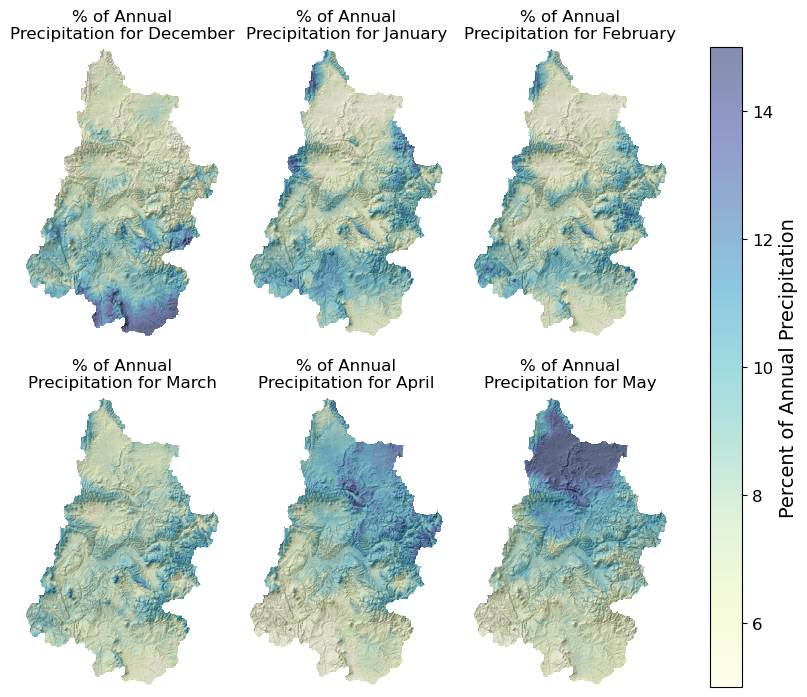

In [40]:

# Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
labels = ['December', 'January', 'February', 'March', 'April', 'May']
fig, axs = plt.subplots(2,3, figsize=(12,8))
axs = axs.ravel()
for i, ds in enumerate([prism_normals_december_annual_percent_ds,
                        prism_normals_january_annual_percent_ds,
                        prism_normals_february_annual_percent_ds,
                        prism_normals_march_annual_percent_ds,
                        prism_normals_april_annual_percent_ds,
                        prism_normals_may_annual_percent_ds]):
    # im = ds.plot(ax=axs[i], cmap='YlGnBu', vmin=20, vmax=40, add_colorbar=False, alpha=0.5)
    axs[i].imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray')
    im = axs[i].imshow(ds.values, alpha=0.5, cmap='YlGnBu', vmin=5, vmax=15)
    axs[i].set_title('% of Annual\nPrecipitation for {}'.format(labels[i]))
    axs[i].set_axis_off()
    # turn off the colorbar
    # set the colorbar label to be Percent Difference
    # cbar = axs[i].collections[0].colorbar
    # cbar.set_label('(%)')
    # plot the hcdn basins
    # ucrb_hcdn_basins.plot(ax=axs[i], facecolor="none", edgecolor="none", linewidth=0.5)
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9, wspace=0, hspace=0.2)
cbar = fig.colorbar(im, ax=axs)
cbar.set_label('Percent of Annual Precipitation', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)

### <a id='toc3_5_2_'></a>[Plot Annual Mean Precipitation](#toc0_)

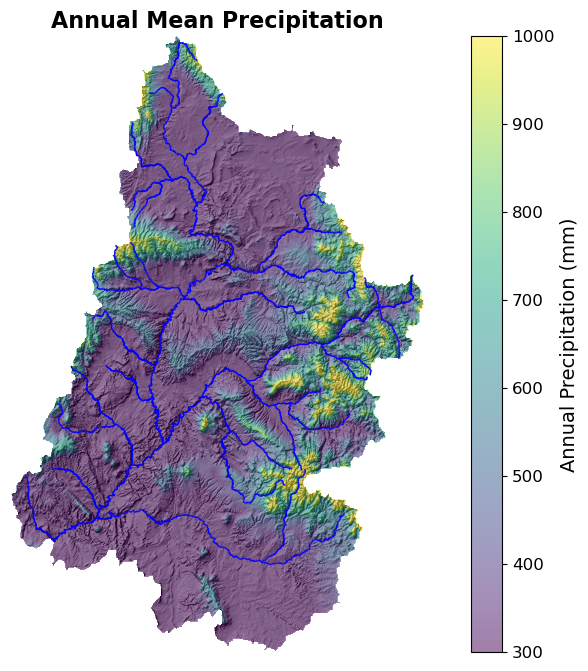

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
# add another plot for the annual mean
ax.imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
im = ax.imshow(prism_normals_annual_ds.values, alpha=0.5, cmap='viridis', vmin=300, vmax=1000,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
# set the colorbar label to be Percent Difference
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Annual Precipitation (mm)', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)
# plot the hcdn basins
# ucrb_hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="none", linewidth=0.5)
ax.set_axis_off()
# add title to axs[4]
ax.set_title('Annual Mean Precipitation', size=16, fontweight='bold')
fig.savefig('../figures/annual_normal_precipitation.png', dpi=700, pad_inches=0.1)


## <a id='toc3_6_'></a>[Plot baseline annual mean precipitation](#toc0_)

### <a id='toc3_6_1_'></a>[Reset resolution to plot 4km PRISM data](#toc0_)

In [48]:
src_4km = rioxr.open_rasterio('../data/geodata/ucrb_dem_32613_150m.tif')
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)

src_4km = src_4km.rio.reproject(dst_crs='EPSG:32613', resolution=3945.843241747955)
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)

dx, dy =3945.843241747955,3945.843241747955

Text(0.5, 1.0, 'Baseline Mean Precipitation')

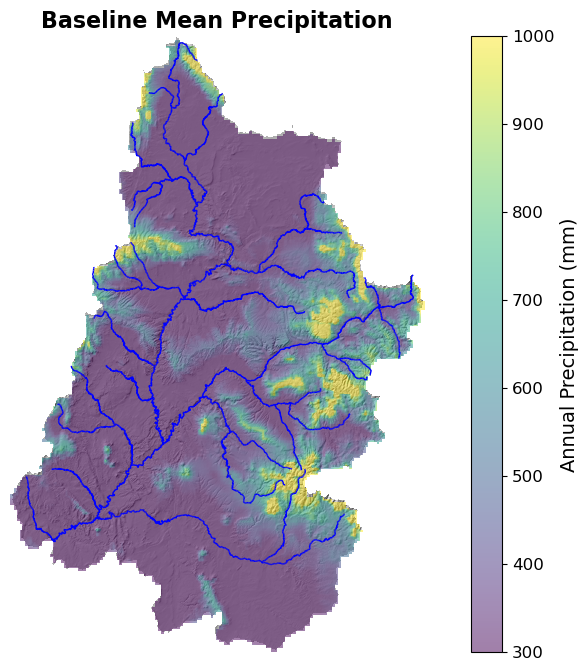

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
# add another plot for the annual mean
ax.imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
im = ax.imshow(prism_4km_pre_annual_ds_ma.mean(dim='month').ppt.values, alpha=0.5, cmap='viridis', vmin=300, vmax=1000,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
# set the colorbar label to be Percent Difference
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Annual Precipitation (mm)', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)
# plot the hcdn basins
# ucrb_hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="none", linewidth=0.5)
ax.set_axis_off()
# add title to axs[4]
ax.set_title('Baseline Mean Precipitation', size=16, fontweight='bold')
# fig.savefig('../figures/annual_normal_precipitation.svg', dpi=700, pad_inches=0.1)


## <a id='toc3_7_'></a>[Plot Millennium Drought annual mean precipitation](#toc0_)

Text(0.5, 1.0, 'Millennium Drought Mean Precipitation')

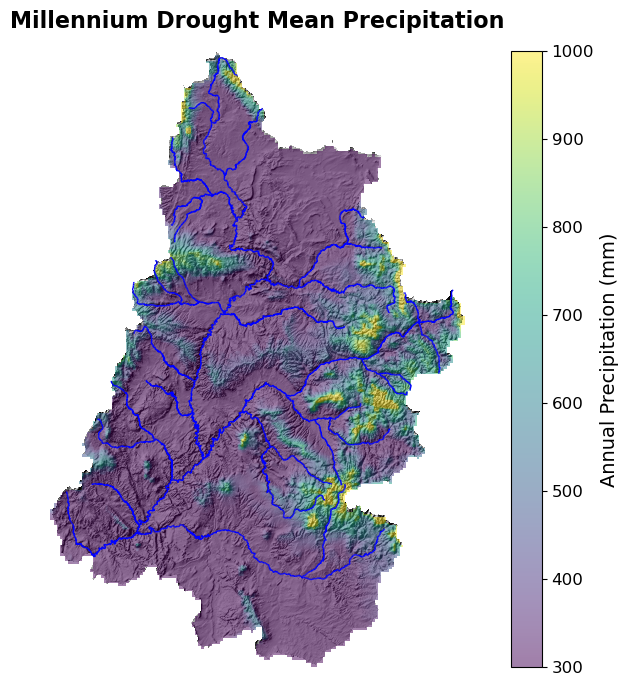

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
# add another plot for the annual mean
ax.imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
im = ax.imshow(prism_4km_post_annual_ds_ma.mean(dim='month').ppt.values, alpha=0.5, cmap='viridis', vmin=300, vmax=1000,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
# set the colorbar label to be Percent Difference
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Annual Precipitation (mm)', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)
# plot the hcdn basins
# ucrb_hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="none", linewidth=0.5)
ax.set_axis_off()
# add title to axs[4]
ax.set_title('Millennium Drought Mean Precipitation', size=16, fontweight='bold')
# fig.savefig('../figures/annual_normal_precipitation.svg', dpi=700, pad_inches=0.1)


## <a id='toc3_8_'></a>[Plot Difference Between Millennium Drought and Baseline Mean Annual Precipitation](#toc0_)

Text(0.5, 1.0, 'Annual Difference Between Periods')

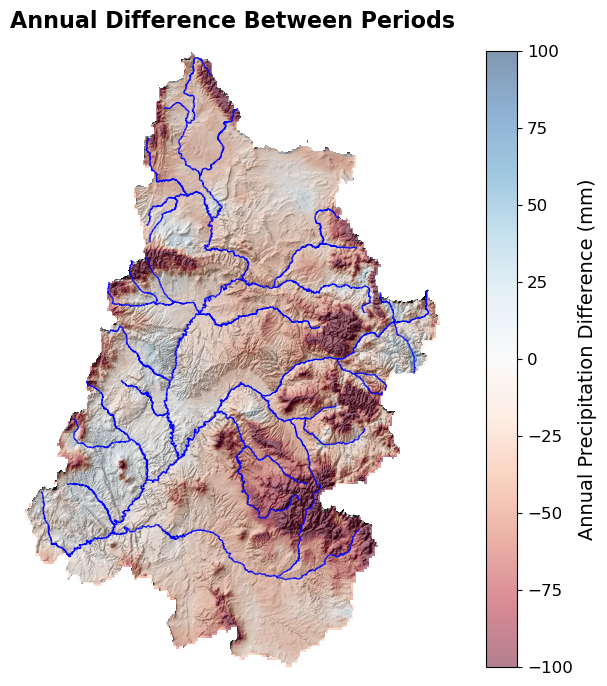

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
# add another plot for the annual mean
ax.imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
im = ax.imshow(prism_4km_post_annual_ds_ma.mean(dim='month').ppt.values - prism_4km_pre_annual_ds_ma.mean(dim='month').ppt.values, 
               alpha=0.5, cmap='RdBu', vmin=-100, vmax=100,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
# set the colorbar label to be Percent Difference
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Annual Precipitation Difference (mm)', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)
# plot the hcdn basins
# ucrb_hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="none", linewidth=0.5)
ax.set_axis_off()
# add title to axs[4]
ax.set_title('Annual Difference Between Periods', size=16, fontweight='bold')
# fig.savefig('../figures/annual_normal_precipitation.svg', dpi=700, pad_inches=0.1)


## <a id='toc3_9_'></a>[Grab HCDN precipitation gages and separate gages with and without significant changes](#toc0_)
This information was produced in the 03_HCDN_elevation_analysis notebook.

In [50]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]
hcdn_basins = hcdn_basins.set_crs(epsg='32613', allow_override=True)

In [51]:
annual_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/annual_significant_change.csv', index_col=0)
annual_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/annual_no_significant_change.csv', index_col=0)
# do the same for the seasonal changes
spring_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/spring_significant_change.csv', index_col=0)
spring_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/spring_no_significant_change.csv', index_col=0)
summer_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/summer_significant_change.csv', index_col=0)
summer_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/summer_no_significant_change.csv', index_col=0)
fall_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/fall_significant_change.csv', index_col=0)
fall_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/fall_no_significant_change.csv', index_col=0)
winter_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/winter_significant_change.csv', index_col=0)
winter_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/winter_no_significant_change.csv', index_col=0)

# read station locations
station_locations = gpd.read_file('../data/geodata/prcp_stations.json')


## <a id='toc3_10_'></a>[Figure used in Manuscript](#toc0_)
This figure is used to show the seasonal difference in precipitation between periods using both precipitation gages and PRISM precipitation. Highlights the large and significant differences between periods during spring.

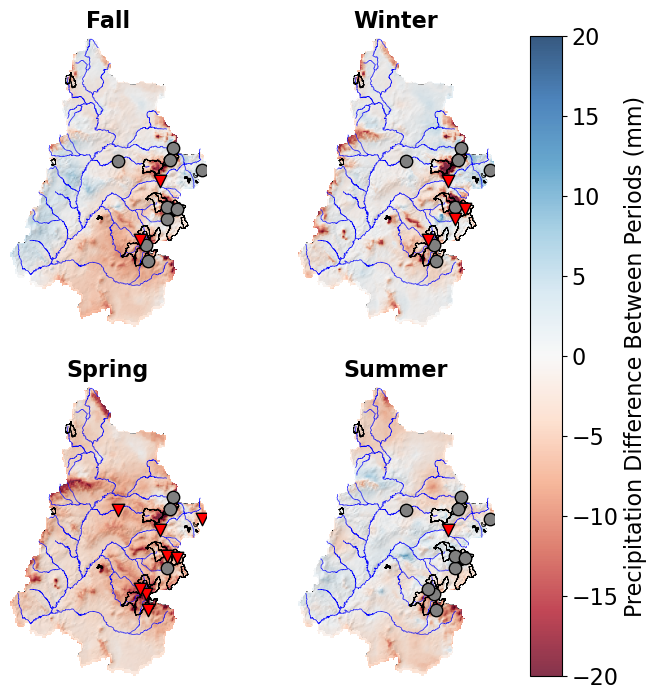

In [52]:
# Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
labels = ['Fall','Winter', 'Spring', 'Summer']
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.ravel()
month_station_dict = {10:[fall_significant_change,fall_no_significant_change],
                      1:[winter_significant_change,winter_no_significant_change],
                      4:[spring_significant_change,spring_no_significant_change],
                      7:[summer_significant_change,summer_no_significant_change],
                      }

for i, month in enumerate([10,1,4,7]):
    
    axs[i].imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['maxy']])
    ucrb_stream_traces.plot(ax=axs[i], color='blue', linewidth=0.5, label='UCRB Streams', zorder=1)                                                                                                            
    im = axs[i].imshow(mean_percent_diff(prism_4km_pre_seasonal_ds_ma, prism_4km_post_seasonal_ds_ma, month)['ppt'].values,
                       cmap='RdBu',alpha=0.8, vmin=-20, vmax=20,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
    # axs[i].set_title('Difference Between\nPeriod Means for {}'.format(labels[i]))
    axs[i].set_title('{}'.format(labels[i]), size=16, fontweight='bold')
    axs[i].set_axis_off()
    # set the colorbar label to be Percent Difference
    # cbar = axs[i].collections[0].colorbar
    # cbar.set_label('Seasonal Precipitation\n Difference (mm)')
    # plot the hcdn basins
    # ax2 = axs[i].twinx()
    hcdn_basins.plot(ax=axs[i], facecolor="none", edgecolor="black", linewidth=0.5, label='HCDN Basins')

    station_locations[station_locations['STATION'].isin(month_station_dict[month][1].index)].plot(ax=axs[i], color='gray', markersize=80, legend=False, ec='k',
                                                                                                    label='Insignificant Decrease or Increase')
# plot station locations included in annual_significant_change with a downward red triangle
    station_locations[station_locations['STATION'].isin(month_station_dict[month][0].index)].plot(ax=axs[i], color='red', markersize=80, marker='v', legend=False,
                                                                                                  label='Significant Decrease (p<0.05)',
                                                                                                  ec='black')
    axs[i].set_xlim([ucrb_basin_boundary.bounds.loc[0]['minx'], ucrb_basin_boundary.bounds.loc[0]['maxx']])
    axs[i].set_ylim([ucrb_basin_boundary.bounds.loc[0]['miny'], ucrb_basin_boundary.bounds.loc[0]['maxy']])
    # # plot ucrb boundary
    # ucrb_basin_boundary.plot(ax=axs[i], facecolor="none", edgecolor="black", linewidth=2)
    # # turn off axis
    # ax2.axis('off')
    # # make the ax2 background transparent
    # ax2.patch.set_alpha(0)
    # if axs[i] == axs[2]:
        # axs[i].legend(loc='upper left', bbox_to_anchor=(0.45, -0.2), fontsize=12)
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0, hspace=0.2)
cbar = fig.colorbar(im, ax=axs)
cbar.set_label('Precipitation Difference Between Periods (mm)', size=16)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=16)
# save figure at 700 dpi and 9x6 centimeters
fig.savefig('../figures/seasonal_precipitation_difference.svg', dpi=700, pad_inches=0.1)

### <a id='toc3_10_1_'></a>[Plot individual changes if necessary](#toc0_)

In [53]:
# # Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
# labels = ['Fall','Winter', 'Spring', 'Summer']

# for i, month in enumerate([10,1,4,7]):
#     fig, ax = plt.subplots(figsize=(12,8))
#     ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
#                                                                                                             ucrb_basin_boundary.bounds.loc[0]['maxx'], 
#                                                                                                             ucrb_basin_boundary.bounds.loc[0]['miny'], 
#                                                                                                             ucrb_basin_boundary.bounds.loc[0]['maxy']])
#     ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=0.5, label='UCRB Streams', zorder=1)                                                                                                            
#     im = ax.imshow(mean_percent_diff(prism_4km_pre_seasonal_ds_ma, prism_4km_post_seasonal_ds_ma, month)['ppt'].values,
#                        cmap='RdBu',alpha=0.8, vmin=-20, vmax=20,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
#                                                                         ucrb_basin_boundary.bounds.loc[0]['maxx'], 
#                                                                         ucrb_basin_boundary.bounds.loc[0]['miny'], 
#                                                                         ucrb_basin_boundary.bounds.loc[0]['maxy']])
#     # ax.set_title('Difference Between\nPeriod Means for {}'.format(labels[i]))
#     ax.set_title('{}'.format(labels[i]), size=16, fontweight='bold')
#     ax.set_axis_off()
#     # create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0, hspace=0.2)
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Precipitation Difference Between Periods (mm)', size=16)
# # increase the size of the tick labels for the colorbar
# cbar.ax.tick_params(labelsize=16)
# # save figure at 700 dpi and 9x6 centimeters


## <a id='toc3_11_'></a>[Plot annual precipitation change between periods](#toc0_)

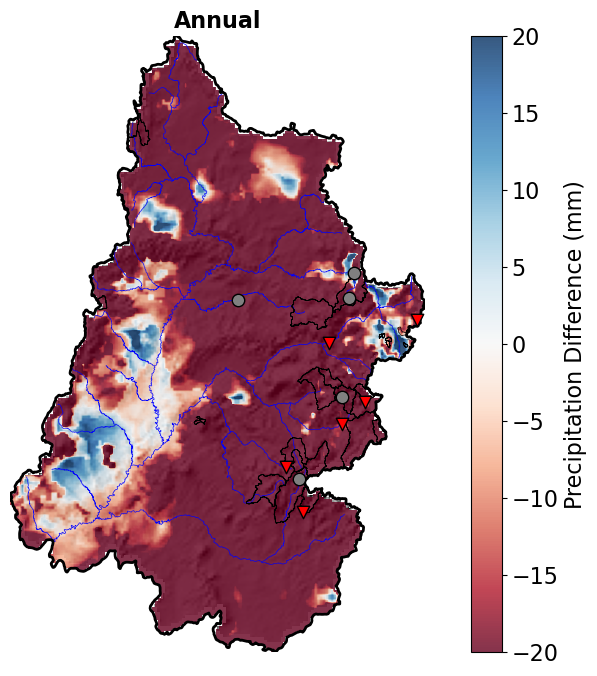

In [54]:
# add another plot for the annual mean
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=0.5, label='UCRB Streams', zorder=1)    
im = ax.imshow(mean_percent_diff(prism_4km_pre_annual_ds_ma, prism_4km_post_annual_ds_ma, None)['ppt'].values, alpha=0.8, cmap='RdBu', vmin=-20, vmax=20,
                                                                        extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])

hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, label='HCDN Basins')
# plot ucrb boundary
ucrb_basin_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)

station_locations[station_locations['STATION'].isin(annual_no_significant_change.index)].plot(ax=ax, color='gray', markersize=80, legend=False, ec='k',
                                                                                                )
# plot station locations included in annual_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(annual_significant_change.index)].plot(ax=ax, color='red', markersize=80, marker='v', legend=False,
                                                                                                ec='black')
# set the colorbar label to be Percent Difference
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Precipitation Difference (mm)', size=16)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=16)

# plot the hcdn basins
# ucrb_hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
ax.set_axis_off()
# add title to ax
ax.set_title('Annual', fontsize=16, fontweight='bold')
# save figure at 700 dpi and 9x6 centimeters
fig.savefig('../figures/annual_precipitation_difference.svg', dpi=700, pad_inches=0.1)